In [1]:
import os
import pandas as pd
import numpy as np
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras import models, optimizers
from keras.applications import VGG16

from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

Using TensorFlow backend.


**Extend the naive solution**
* Use VGG16 pretrained on ImageNet
    * ImageNet dataset contains 1.4million labeled images and 1000 classes

#### Read data
The dataset has the following directory structure:

<pre>
<b>10-monkey-species/</b>
|__ <b>training</b>
    |______ <b>species_{1}</b>: [species_{1}.jpg, species_{2}.jpg, ... species_{n}]
    |______ <b>species_{2}</b>: [species_{1}.jpg, species_{2}.jpg, ... species_{n}]
    |           .
    |           .
    |______ <b>species_{n}</b>: [species_{1}.jpg, species_{2}.jpg, ... species_{n}]
|__ <b>validation</b>
    |______ <b>species_{1}</b>: [species_{1}.jpg, species_{2}.jpg, ... species_{n}]
    |______ <b>species_{2}</b>: [species_{1}.jpg, species_{2}.jpg, ... species_{n}]
    |           .
    |           .
    |______ <b>species_{n}</b>: [species_{1}.jpg, species_{2}.jpg, ... species_{n}]
</pre>

In [2]:
PATH = '/Users/fi000980702/Documents/Work/Chapter5/10-monkey-species/'
train_dir = os.path.join(PATH, 'training')
val_dir = os.path.join(PATH, 'validation')

In [3]:
monkey_species = ['mantled_howler', 'patas_monkey', 'bald_uakari', 
                  'japanese_macaque', 'pygmy_marmoset','white_headed_capuchin',
                  'silvery_marmoset', 'common_squirrel_monkey', 'black_headed_night_monkey', 'nilgiri_langur']

In [4]:
train_lengths = []
validation_lengths = []

for i, species in enumerate(monkey_species):
    train_lengths.append(len(os.listdir(os.path.join(train_dir, species))))
    validation_lengths.append(len(os.listdir(os.path.join(val_dir, species))))
    print('Total training {:s} images {:d}'.format(species, train_lengths[i]))
    print('Total validation {:s} images {:d}'.format(species, validation_lengths[i]))
    print("--")
    
print('Total training samples',np.sum(train_lengths))
print('Total validation samples', np.sum(validation_lengths))

Total training mantled_howler images 105
Total validation mantled_howler images 26
--
Total training patas_monkey images 111
Total validation patas_monkey images 28
--
Total training bald_uakari images 110
Total validation bald_uakari images 27
--
Total training japanese_macaque images 122
Total validation japanese_macaque images 30
--
Total training pygmy_marmoset images 105
Total validation pygmy_marmoset images 26
--
Total training white_headed_capuchin images 113
Total validation white_headed_capuchin images 28
--
Total training silvery_marmoset images 106
Total validation silvery_marmoset images 26
--
Total training common_squirrel_monkey images 114
Total validation common_squirrel_monkey images 28
--
Total training black_headed_night_monkey images 106
Total validation black_headed_night_monkey images 27
--
Total training nilgiri_langur images 106
Total validation nilgiri_langur images 26
--
Total training samples 1098
Total validation samples 272


#### Pretrained VGG16 on ImageNet
* We omit the densely connected layer because the representations learned by the convolutional layer are likely to be more generic and therefore more reusable whereas the representations learned by the classifier will necessarily be spesific to the set of classes on which the model was trained. Therefore we set ```include_top=False```

In [5]:
image_height = 300
image_width = 300
channels = 3
batch_size = 20
epochs = 8

In [6]:
conv_base = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=(image_height, image_width, channels),
    pooling='max')
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [9]:
# Set up augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest') 

# Validation data will not augmented
val_datagen = ImageDataGenerator(rescale=1./255) 

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, 
    target_size=(image_width, image_height), 
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. 

Additionally, we will fine-tune the last 3 convolutional layers, which means that all layers up until **block4_pool** should be frozen, and the layers **block5_conv1, block5_conv2 and block5_conv3** should be trainable. We fine-fune only the last three layers because earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. Therefore, it is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem.

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model = Sequential()
for layer in conv_base.layers:
    model.add(layer)
#base_model.trainable = False
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

adam = optimizers.Adam(lr=1e-4, epsilon=1e-08, decay=1e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 75, 75, 256)      

Below we saa that the last three convolutional layers in addition to the dense layers are all trainable whereas the preceeding layers are frozen.

In [13]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x138368a90> False
<keras.layers.convolutional.Conv2D object at 0x106f35190> False
<keras.layers.pooling.MaxPooling2D object at 0x138405a90> False
<keras.layers.convolutional.Conv2D object at 0x138426dd0> False
<keras.layers.convolutional.Conv2D object at 0x1384ad2d0> False
<keras.layers.pooling.MaxPooling2D object at 0x1384ad950> False
<keras.layers.convolutional.Conv2D object at 0x1384c0710> False
<keras.layers.convolutional.Conv2D object at 0x1384cac50> False
<keras.layers.convolutional.Conv2D object at 0x1384caa90> False
<keras.layers.pooling.MaxPooling2D object at 0x1384d9990> False
<keras.layers.convolutional.Conv2D object at 0x138537d90> False
<keras.layers.convolutional.Conv2D object at 0x13854ba50> False
<keras.layers.convolutional.Conv2D object at 0x138537e10> False
<keras.layers.pooling.MaxPooling2D object at 0x1385915d0> False
<keras.layers.convolutional.Conv2D object at 0x138591850> True
<keras.layers.convolutional.Conv2D object

In [14]:
start_time = time.time()     

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=1, 
    verbose=1, 
    factor=0.3, 
    min_lr=1e-5)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=np.sum(train_lengths)//batch_size, 
    epochs=epochs,
    validation_data=val_generator, 
    validation_steps=np.sum(validation_lengths)//batch_size,
    callbacks=[lr_plateau])

total_time = (time.time() - start_time)/60                                     
print('Execution time {:2f} minutes'.format(total_time))    

Epoch 1/8
54/54 [==============================] - 855s 16s/step - loss: 2.1457 - acc: 0.2523 - val_loss: 1.6092 - val_acc: 0.6231
Epoch 2/8
54/54 [==============================] - 837s 15s/step - loss: 1.2182 - acc: 0.5881 - val_loss: 0.4998 - val_acc: 0.8095
Epoch 3/8
54/54 [==============================] - 833s 15s/step - loss: 0.8126 - acc: 0.7254 - val_loss: 0.4082 - val_acc: 0.8690
Epoch 4/8
54/54 [==============================] - 851s 16s/step - loss: 0.4685 - acc: 0.8423 - val_loss: 0.2749 - val_acc: 0.8889
Epoch 5/8
54/54 [==============================] - 875s 16s/step - loss: 0.4110 - acc: 0.8627 - val_loss: 0.1972 - val_acc: 0.9048
Epoch 6/8
54/54 [==============================] - 838s 16s/step - loss: 0.3128 - acc: 0.9045 - val_loss: 0.2802 - val_acc: 0.9365

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 7/8
54/54 [==============================] - 834s 15s/step - loss: 0.2018 - acc: 0.9315 - val_loss: 0.1178 - val_acc: 0.9484
E

In [15]:
model.save('vgg16_multi_w_aug.h5')

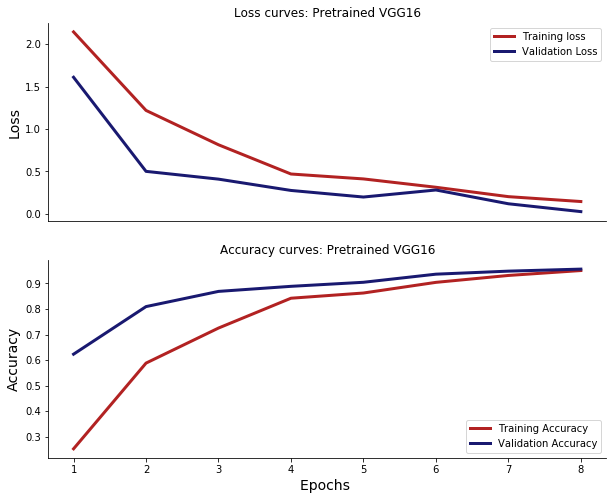

In [16]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves: Pretrained VGG16')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves: Pretrained VGG16')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')